# Lab Instructions

You are working as an analyst for a consulting agency that has been hired to study and improve productivity at a mid-sized company.  Morale is very low and, after speaking with employees, several common complaints kept coming up:

* New employees complained that more tenured employees were lazy and unproductive.
* More tenured employees complained that the newer employees didn't focus and were therefore unproductive.
* Managers were worried that remote workers might be less productive.
* In-person employees found it impossible to focus and be productive when their desk was in the open plan area.
* Many people said they had so much administrative work to do they could only be truly productive if they worked overtime.
* Everyone complained that there were too many meetings.

The consulting agency carefully collected data on a number of factors including number of years at the company, focus (higher is better), productivity (higher is better), department, meetings per week, and desk location can be found in Employee_productivity.csv.

1. Determine which feature - years at the company, hours worked, or focus - has the strongest linear relationship with productivity.  Show a visualization and calculate R-squared for all three relationships to justify your answer.

2. Build on that linear regression model to determine what other featuers also impact productivity. Using both visualzations and R-squared values, build a model that can predicts employee productivity at this company. Evaluate each feature in the dataset.

3. Write a short (a few sentences) summary of how the different factors in the data relate to employee productivity.  What recommendations would you make so that employees can be as productive as possible?



R² for YearsAtCompany → Productivity: 0.000


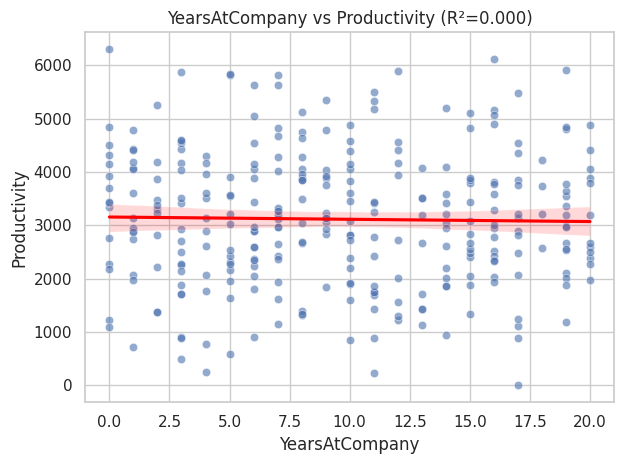

R² for HoursWorked → Productivity: 0.003


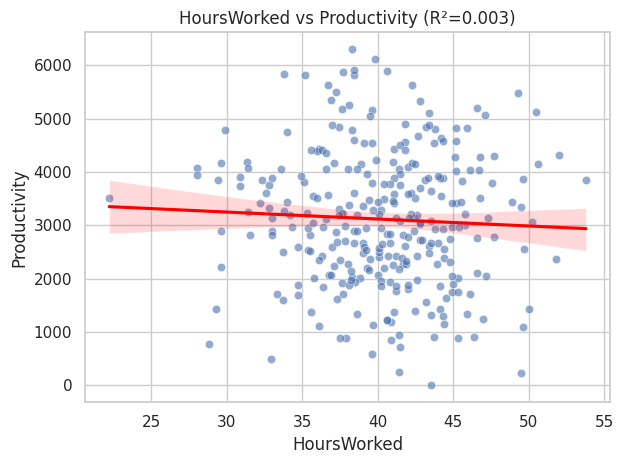

R² for Focus → Productivity: 0.678


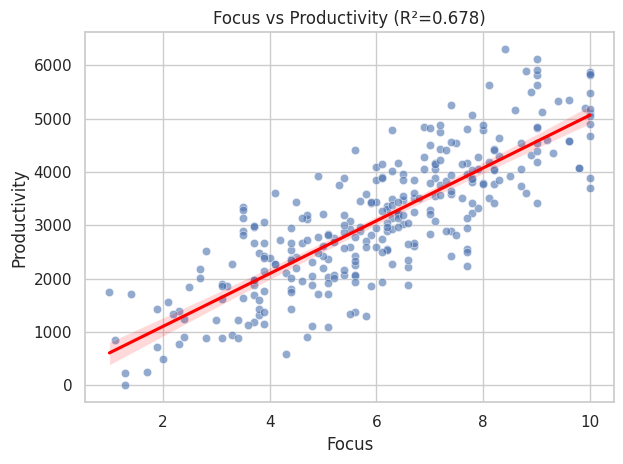


R² Summary:
          Feature  R_squared
2           Focus   0.677696
1     HoursWorked   0.002600
0  YearsAtCompany   0.000412


In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load and normalize dataset
df = pd.read_csv("Employee_productivity.csv")
df = df.rename(columns={
    "ProductivityScore": "Productivity",
    "FocusScore": "Focus",
    "TeamMeetingsPerWeek": "MeetingsPerWeek"
})

# Keep numeric subset
df_num = df.dropna(subset=["Productivity", "YearsAtCompany", "HoursWorked", "Focus"])

# Simple function for R² and visualization
def r2_simple(x_col, y_col="Productivity", data=df_num):
    X = sm.add_constant(data[x_col])
    y = data[y_col]
    model = sm.OLS(y, X).fit()
    r2 = model.rsquared
    print(f"R² for {x_col} → {y_col}: {r2:.3f}")
    sns.scatterplot(x=x_col, y=y_col, data=data, alpha=0.6)
    sns.regplot(x=x_col, y=y_col, data=data, scatter=False, color="red")
    plt.title(f"{x_col} vs {y_col} (R²={r2:.3f})")
    plt.tight_layout()
    plt.show()
    return r2

# Run comparisons
r2_years  = r2_simple("YearsAtCompany")
r2_hours  = r2_simple("HoursWorked")
r2_focus  = r2_simple("Focus")

# Display R² table
r2_table = pd.DataFrame({
    "Feature": ["YearsAtCompany", "HoursWorked", "Focus"],
    "R_squared": [r2_years, r2_hours, r2_focus]
}).sort_values("R_squared", ascending=False)

print("\nR² Summary:")
print(r2_table)

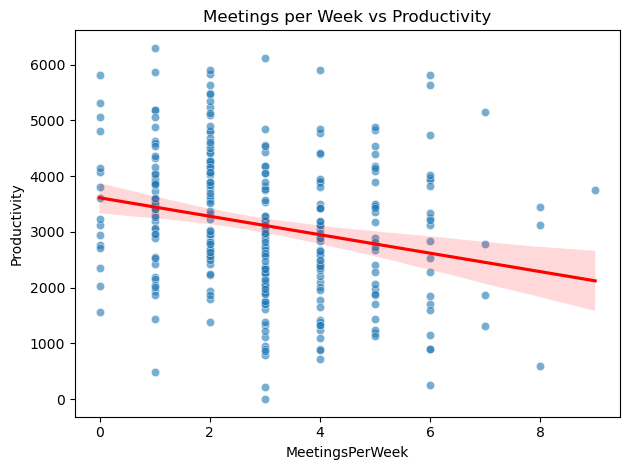

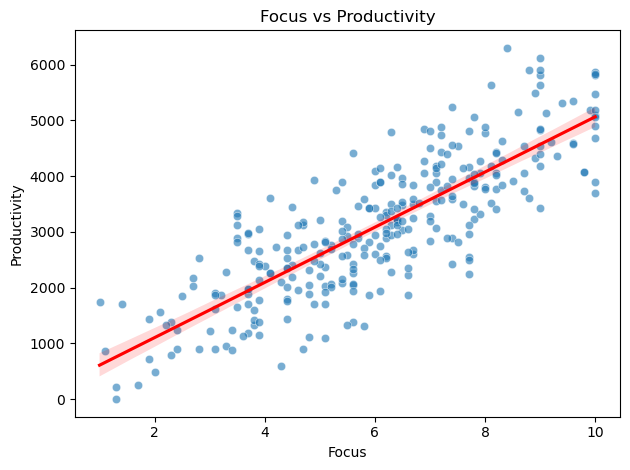

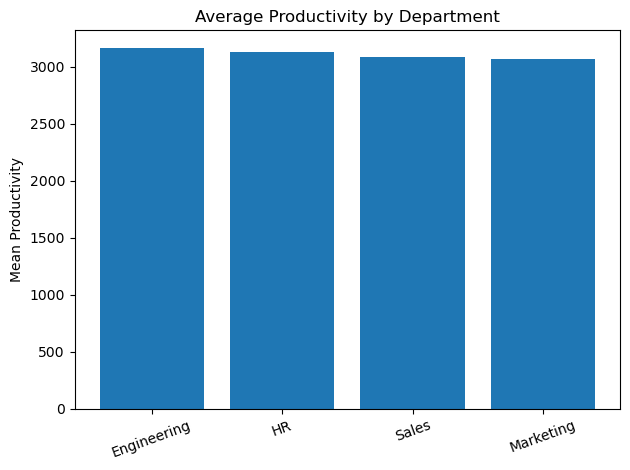

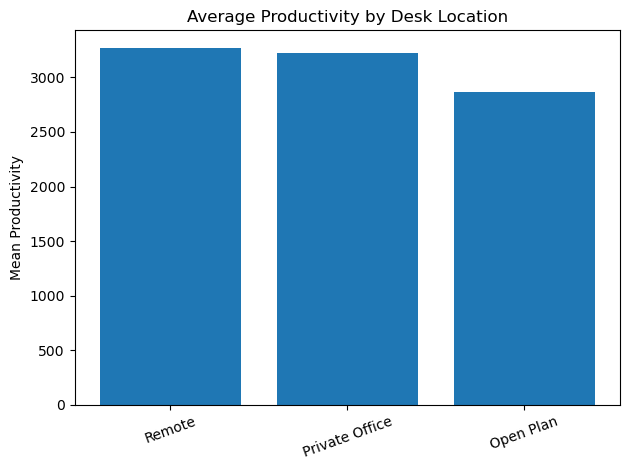

                            OLS Regression Results                            
Dep. Variable:           Productivity   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     78.54
Date:                Mon, 20 Oct 2025   Prob (F-statistic):           3.55e-68
Time:                        14:24:59   Log-Likelihood:                -2391.6
No. Observations:                 300   AIC:                             4801.
Df Residuals:                     291   BIC:                             4834.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             105.8476    405.287     

In [1]:
# ============================================================
# Q2 — Build multifeature linear model with multiple predictors 
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load and rename
df = pd.read_csv("Employee_productivity.csv")
df = df.rename(columns={
    "ProductivityScore": "Productivity",
    "FocusScore": "Focus",
    "TeamMeetingsPerWeek": "MeetingsPerWeek"
})

# Safe source series (Series default so .astype works even if missing)
remote_src = df.get("WorkMode", pd.Series("", index=df.index))
desk_src   = df.get("DeskLocation", pd.Series("", index=df.index))

# Binary helpers
df["remote_num"]    = remote_src.fillna("").astype(str).str.lower().str.contains("remote").astype(int)
df["open_plan_num"] = desk_src.fillna("").astype(str).str.lower().str.contains("open").astype(int)

# One-hot encode department
dept_dummies = pd.get_dummies(df["Department"], prefix="dept", drop_first=True)

# --- Build numeric predictor block first, coercing to numeric ---
base_pred_cols = ["YearsAtCompany", "HoursWorked", "Focus", "MeetingsPerWeek", "remote_num", "open_plan_num"]
pred_num = df[base_pred_cols].apply(pd.to_numeric, errors="coerce")

# Combine numeric predictors + department dummies, ensure float dtype
X = pd.concat([pred_num, dept_dummies], axis=1).apply(pd.to_numeric, errors="coerce").astype(float)

# Target variable
y = pd.to_numeric(df["Productivity"], errors="coerce").astype(float)

# Drop rows with missing values
mask = X.join(y).dropna().index
X = X.loc[mask]
y = y.loc[mask]

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()


sns.scatterplot(x="MeetingsPerWeek", y="Productivity", data=df, alpha=0.6)
sns.regplot(x="MeetingsPerWeek", y="Productivity", data=df, scatter=False, color="red")
plt.title("Meetings per Week vs Productivity")
plt.tight_layout()
plt.show()

sns.scatterplot(x="Focus", y="Productivity", data=df, alpha=0.6)
sns.regplot(x="Focus", y="Productivity", data=df, scatter=False, color="red")
plt.title("Focus vs Productivity")
plt.tight_layout()
plt.show()

dept_means = df.groupby("Department")["Productivity"].mean().sort_values(ascending=False)
plt.bar(dept_means.index, dept_means.values)
plt.title("Average Productivity by Department")
plt.ylabel("Mean Productivity")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

if "DeskLocation" in df.columns:
    desk_means = df.groupby("DeskLocation")["Productivity"].mean().sort_values(ascending=False)
    plt.bar(desk_means.index, desk_means.values)
    plt.title("Average Productivity by Desk Location")
    plt.ylabel("Mean Productivity")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


if "WorkMode" in df.columns:
    mode_means = df.groupby("WorkMode")["Productivity"].mean().sort_values(ascending=False)
    plt.bar(mode_means.index, mode_means.values)
    plt.title("Average Productivity by Work Mode")
    plt.ylabel("Mean Productivity")
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()
# --- Output summary ---
print(model.summary())
print("\nR² (full model):", round(model.rsquared, 3))
print("Adj R² (full model):", round(model.rsquared_adj, 3))

# Coefficients sorted by absolute effect size
coef_table = (
    model.params.drop("const")
    .to_frame("coef")
    .join(model.pvalues.drop("const").to_frame("p_value"))
    .assign(abs_coef=lambda d: d["coef"].abs())
    .sort_values("abs_coef", ascending=False)
)
print("\nEstimated effects (sorted by magnitude):")
print(coef_table[["coef", "p_value"]])

In [ ]:
if "WorkMode" in df.columns or "work_mode" in [c.lower() for c in df.columns]:
    work_col = [c for c in df.columns if c.lower() in ["workmode","work_mode"]][0]
    df["remote_num"] = df[work_col].astype(str).str.lower().str.contains("remote").astype(int)
else:
    df["remote_num"] = 0


if "DeskLocation" in df.columns or "desk_location" in [c.lower() for c in df.columns]:
    desk_col = [c for c in df.columns if c.lower() in ["desklocation","desk_location"]][0]
    df["open_plan_num"] = df[desk_col].astype(str).str.lower().str.contains("open").astype(int)
else:
    df["open_plan_num"] = 0


df_num = df.dropna(subset=["Productivity", "YearsAtCompany", "HoursWorked", "Focus"])

print("Binary columns added: remote_num, open_plan_num")
print(df_num.head())

Binary columns added: remote_num, open_plan_num
   HoursWorked  Focus  Productivity   Department  YearsAtCompany  \
0         42.4    6.3       3127.96  Engineering              17   
1         34.0    7.2       4742.60           HR               8   
2         47.2    5.6       2044.73        Sales              15   
3         38.4    9.0       5818.92           HR               5   
4         36.4    2.5       1841.31        Sales               9   

   MeetingsPerWeek    DeskLocation  remote_num  open_plan_num  
0                0       Open Plan           0              1  
1                6  Private Office           0              0  
2                3          Remote           0              0  
3                6  Private Office           0              0  
4                6          Remote           0              0  
